## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet

# Настройка pandas для отображения всех столбцов
pd.set_option('display.max_columns', None)

## 2. Определение вспомогательных функций

Этот блок содержит все функции, которые буду использовать в дальнейшем

In [2]:
def create_date_column(df: pd.DataFrame, year_col: str = 'year', week_col: str = 'week_number') -> pd.DataFrame:
    """Создает столбец 'date' на основе года и номера недели."""
    def get_date(row):
        year = int(row[year_col])
        week = int(row[week_col])
        return pd.to_datetime(f"{year}-W{week}-1", format="%Y-W%W-%w")

    df['date'] = df.apply(get_date, axis=1)
    return df


def aggregate_weekly_data(df: pd.DataFrame, group_cols: list, value_col: str, agg_func: str = 'sum') -> pd.DataFrame:
    """Агрегирует данные по неделям и указанным столбцам."""
    weekly_data = df.groupby(group_cols)[value_col].agg(agg_func).reset_index()
    return weekly_data


def interpolate_with_group_mean(df: pd.DataFrame, value_col: str = 'checks_qty', group_cols: list = ['regionrf_name', 'restformat_name', 'year', 'week_number']) -> pd.Series:
    """Заполняет пропуски, используя среднее по группе и линейную интерполяцию.

    Применяет:
    1. Заполнение средним по группе (регион, формат, год, неделя).
    2. Линейную интерполяцию для оставшихся пропусков.
    3. Сглаживание скользящим средним.
    """
    # 1. Заполнение средним
    df_grouped = df.groupby(group_cols)[value_col].transform('mean')
    df_filled = df[value_col].fillna(df_grouped)

    # 2. Линейная интерполяция (если еще есть пропуски)
    series_filled = df_filled.fillna(0)
    non_zero_indices = series_filled[series_filled != 0].index
    if len(non_zero_indices) > 0:
      first_non_zero = non_zero_indices.min()
      last_non_zero = non_zero_indices.max()
      series_filled.loc[first_non_zero:last_non_zero] = series_filled.loc[first_non_zero:last_non_zero].replace(0, np.nan)
      series_interpolated = series_filled.interpolate(method='linear', limit_direction='both') # Интерполируем, если надо
    else:
      series_interpolated = series_filled
    # 3. Сглаживание скользящим средним
    series_smoothed = series_interpolated.rolling(window=3, center=True, min_periods=1).mean()
    return series_smoothed


def detect_outliers_prophet_with_regressors(df: pd.DataFrame, value_col: str = 'checks_qty_interp',
                                            interval_width: float = 0.999,
                                            original_index: pd.Index = None,
                                            regressors: list = None) -> pd.Series:
    """Находит выбросы с помощью Prophet и регрессоров."""
    df_prophet = df[['date', value_col] + regressors].rename(columns={'date': 'ds', value_col: 'y'})

    # One-hot для категориальных регрессоров
    df_prophet = pd.get_dummies(df_prophet, columns=regressors, drop_first=True)

    model = Prophet(interval_width=interval_width, seasonality_mode='additive')
    for col in df_prophet.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)

    model.fit(df_prophet)
    forecast = model.predict(df_prophet)
    df_merged = df_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
    df_merged['is_outlier'] = (df_merged['y'] < df_merged['yhat_lower']) | (df_merged['y'] > df_merged['yhat_upper'])
    return pd.Series(df_merged['is_outlier'].values, index=original_index)


def plot_restaurant_data(restaurant_data: pd.DataFrame, value_col: str, outliers_col: str, title_prefix: str = "Restaurant") -> None:
    """Рисует график данных ресторана с выбросами."""
    fig, ax = plt.subplots(figsize=(16, 8))
    color_original = 'skyblue'
    color_filtered = 'mediumseagreen'
    color_outliers = 'crimson'

    sns.lineplot(x='date', y=value_col, data=restaurant_data, label=f'Исходные данные ({value_col})', color=color_original, linewidth=1.5, ax=ax)
    sns.lineplot(x='date', y='checks_qty_interp_filtered', data=restaurant_data, label='Сглаженные данные, без выбросов', color=color_filtered, linewidth=2, ax=ax)
    sns.scatterplot(x=restaurant_data[restaurant_data[outliers_col]]['date'],
                    y=restaurant_data[restaurant_data[outliers_col]][value_col],
                    color=color_outliers, label=f'Выбросы ({len(restaurant_data[restaurant_data[outliers_col]])})',
                    marker='x', s=80, linewidths=2, ax=ax)

    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество чеков')
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1.05), borderaxespad=0., fontsize=10)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    sns.despine(top=True, right=True)
    plt.title(f'{title_prefix} {restaurant_data["rest_ncode"].iloc[0]}: Анализ чеков', fontsize=14) # Чуть менее формальное название графика
    plt.tight_layout()
    plt.show()




def calculate_seasonality_coefficients(weekly_checks_full: pd.DataFrame, value_col: str, smoothing_window: int = 3) -> pd.DataFrame:
    """Вычисляет коэффициенты сезонности, сглаживая их скользящим средним и заполняя NaN значения 1.0.

    В этой версии, NaN коэффициенты заменяются на 1.0, представляя нейтральную сезонность для sparse данных.
    """
    # 1. Среднее для каждого ресторана за весь период
    group_weekly_avg = weekly_checks_full.groupby('rest_ncode')[value_col].mean().reset_index()
    group_weekly_avg.rename(columns={value_col: 'group_avg'}, inplace=True)

    # 2. Объединяем с исходными данными
    weekly_avg = weekly_checks_full.merge(group_weekly_avg, on='rest_ncode', how='left')

    # 3. Расчет коэффициента сезонности (относительно среднего по ресторану)
    weekly_avg['seasonality_coeff'] = weekly_avg[value_col] / weekly_avg['group_avg']

    # 4. Сглаживание
    weekly_avg['seasonality_coeff_smoothed'] = weekly_avg.groupby('rest_ncode')['seasonality_coeff'].transform(
        lambda x: x.rolling(window=smoothing_window, center=True, min_periods=1).mean()
    )

    # 5. Заполнение NaN значений на 1.0
    weekly_avg['seasonality_coeff_smoothed'] = weekly_avg['seasonality_coeff_smoothed'].fillna(1.0) # Заполнение NaN на 1.0

    #Удаляем более не нужный столбец
    weekly_avg = weekly_avg.drop('group_avg', axis=1)

    return weekly_avg


def create_result_tables(weekly_avg: pd.DataFrame) -> tuple[pd.DataFrame, int, pd.DataFrame]:
    """Создает таблицы результатов."""
    table1 = weekly_avg.groupby('rest_ncode')['week_number'].count().reset_index()
    table1.columns = ['Ресторан', 'Кол-во недель c заполненным коэфф-том']
    table2_count = weekly_avg[(weekly_avg['seasonality_coeff_smoothed'] > 2) | (weekly_avg['seasonality_coeff_smoothed'] < 0.4)].shape[0]
    table3 = weekly_avg[['rest_ncode', 'week_number', 'seasonality_coeff_smoothed']]
    table3.columns = ['Ресторан', 'Неделя', 'Коэфф-т сезонности']
    return table1, table2_count, table3

## 3. Загрузка и предобработка данных

In [3]:
df = pd.read_csv("rest_checks.csv", sep=";", parse_dates=["check_dt"], date_format='mixed')

df['week_number'] = df['check_dt'].dt.isocalendar().week
df['year'] = df['check_dt'].dt.isocalendar().year

print(f"Минимальная дата: {df['check_dt'].min()}")
print(f"Максимальная дата: {df['check_dt'].max()}")
print("\nПервые 5 строк данных:")
display(df.head())
print("\nИнформация о пропусках:")
display(df.isnull().sum())

Минимальная дата: 2023-01-01 00:00:00
Максимальная дата: 2024-12-29 00:00:00

Первые 5 строк данных:


,rest_ncode,check_dt,checks_qty,regionrf_name,restformat_name,week_number,year
0,1031,2024-10-13,298,Волгоградская область,IL,41,2024
1,70,2023-06-09,379,Город Москва,FC,23,2023
2,1025,2023-01-06,146,Нижегородская область,FC,1,2023
3,887,2024-01-30,169,Московская область,IL,5,2024
4,313,2024-01-25,132,Курская область,FC,4,2024



Информация о пропусках:


rest_ncode         0
check_dt           0
checks_qty         0
regionrf_name      0
restformat_name    0
week_number        0
year               0
dtype: int64

## 4. Агрегация данных и создание полного набора недель

1.  Агрегируем исходные данные по ресторанам и неделям (`weekly_checks`).
2.  Создаем все возможные комбинации "ресторан - год - неделя" (`all_weeks_df`).
3.  Дополняем `all_weeks_df` данными о продажах из `weekly_checks`, пропуски заполняем нулями.
4.  Добавляем столбец `date`.

In [4]:
# Агрегация данных по ресторанам и неделям
weekly_checks = aggregate_weekly_data(df, ['rest_ncode', 'year', 'week_number'], 'checks_qty')

# Создание полного набора комбинаций "ресторан - год - неделя"
all_restaurants = df['rest_ncode'].unique()
all_weeks = pd.MultiIndex.from_product(
    [all_restaurants, [2023, 2024], range(1, 53)],
    names=['rest_ncode', 'year', 'week_number']
)
all_weeks_df = pd.DataFrame(index=all_weeks).reset_index()

# Объединение полного набора с фактическими данными
weekly_checks_full = all_weeks_df.merge(weekly_checks, on=['rest_ncode', 'year', 'week_number'], how='left')

# Заполнение пропущенных значений нулями (первичная обработка)
weekly_checks_full['checks_qty'] = weekly_checks_full['checks_qty'].fillna(0)

# Создание столбца 'date' (после заполнения пропусков, чтобы избежать ошибок)
weekly_checks_full = create_date_column(weekly_checks_full)

weekly_checks_full = weekly_checks_full.merge(df[['rest_ncode', 'regionrf_name', 'restformat_name']].drop_duplicates(), on='rest_ncode', how='left')

## 5. Интерполяция пропусков

**Метод:** Комбинированная интерполяция:

1.  **Среднее по группе (регион, формат, год, неделя):** Учёт локальных трендов.
2.  **Линейная интерполяция:** Если среднее по группе недоступно.
3.  **Сглаживание (скользящее среднее, окно=3):** Устранение резких скачков.

**Обоснование:**

*   Линейная интерполяция подходит для плавного изменения значений (количество чеков по неделям).
*   Среднее по группе повышает точность, учитывая особенности ресторана.
*   Сглаживание уменьшает "шум".

**Альтернативы (не подходят):**

*   **Нули:** Искажают анализ сезонности.
*   **Среднее по ресторану:** Не учитывает недельную специфику.
*   **Сплайны/полиномы:** Риск переобучения. Линейная интерполяция проще и надёжнее.

In [5]:
weekly_checks_full['checks_qty_interp'] = weekly_checks_full.groupby('rest_ncode', group_keys=False)[['checks_qty', 'regionrf_name', 'restformat_name', 'year', 'week_number']].apply(
    lambda group: interpolate_with_group_mean(group, value_col='checks_qty')
)

## 6. Обнаружение и обработка выбросов с помощью Prophet

**Задача:** Выявить и скорректировать аномальные значения количества чеков, искажающие расчёт сезонности.

**Метод:** Модель Prophet.

**Обоснование:**

*   **Специализация:** Prophet предназначен для анализа временных рядов с сезонностью (годовой, недельной).
*   **Доверительные интервалы:** Широкий интервал (99.9%) для выявления только экстремальных выбросов.
*   **Устойчивость к пропускам:** Важно при наличии пропущенных данных.
*   **Регрессоры:** Учёт влияния региона и формата ресторана через категориальные регрессоры (One-Hot Encoding перед подачей в модель).

**Параметры:**

*   `interval_width=0.999`:  Высокая чувствительность к выбросам.
*   `seasonality_mode='additive'`:  Предполагается аддитивная сезонность.

**Обработка:**

Выбросы, определённые Prophet, заменяются на `NaN`. Далее применяется комбинированная интерполяция:

1.  **Среднее по группе (регион, формат, неделя, год):**  Заполнение пропуска средним значением по схожим ресторанам.
2.  **Линейная интерполяция:**  Если среднее по группе недоступно, используется линейная интерполяция внутри временного ряда ресторана.

Этот подход сглаживает выбросы, учитывая контекст (регион, формат) при восстановлении значений.

In [6]:
# Обнаружение выбросов с использованием модели Prophet и регрессоров (регион и формат).
# Применяем функцию detect_outliers_prophet_with_regressors к каждой группе (отдельному ресторану).
weekly_checks_full['is_outlier'] = weekly_checks_full.groupby('rest_ncode', group_keys=False).apply(
    lambda group: detect_outliers_prophet_with_regressors(
        group.reset_index(),  # Сбрасываем индекс, чтобы Prophet мог корректно работать с датами.
        value_col='checks_qty_interp',  # Используем интерполированные данные.
        original_index=group.index,  # Сохраняем исходный индекс, чтобы корректно проставить метки выбросов.
        regressors=['regionrf_name', 'restformat_name']  # Передаем список регрессоров.
    ), include_groups=False # Не включаем группирующую переменную (rest_ncode) в результат.
)

# Копируем столбец с интерполированными данными для дальнейшей обработки.
weekly_checks_full['checks_qty_interp_filtered'] = weekly_checks_full['checks_qty_interp']

# Заменяем значения, помеченные как выбросы, на NaN.
weekly_checks_full.loc[weekly_checks_full['is_outlier'], 'checks_qty_interp_filtered'] = np.nan

# Выполняем комбинированную интерполяцию (сначала среднее по группе, затем линейная).
# Группируем по 'rest_ncode', но интерполируем внутри группы с учетом региона, формата, года и недели.
weekly_checks_full['checks_qty_interp_filtered'] = weekly_checks_full.groupby('rest_ncode', group_keys=False)[['checks_qty_interp_filtered', 'regionrf_name', 'restformat_name', 'year', 'week_number']].apply(
        lambda group: interpolate_with_group_mean(group, value_col='checks_qty_interp_filtered', group_cols=['regionrf_name', 'restformat_name', 'year', 'week_number'])
)

03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:44 - cmdstanpy - INFO - Chain [1] start processing
03:22:44 - cmdstanpy - INFO - Chain [1] done processing
03:22:44 - cmdstanpy - INFO - Chain [1] start processing
03:22:44 - cmdstanpy - INFO - Chain [1]

## 7. Построение графиков для визуализации обработки выбросов

Строим графики для нескольких ресторанов, чтобы визуально оценить результаты обработки выбросов. \
На графиках отображаются исходные данные, данные после интерполяции и сглаживания, а также сами выбросы.

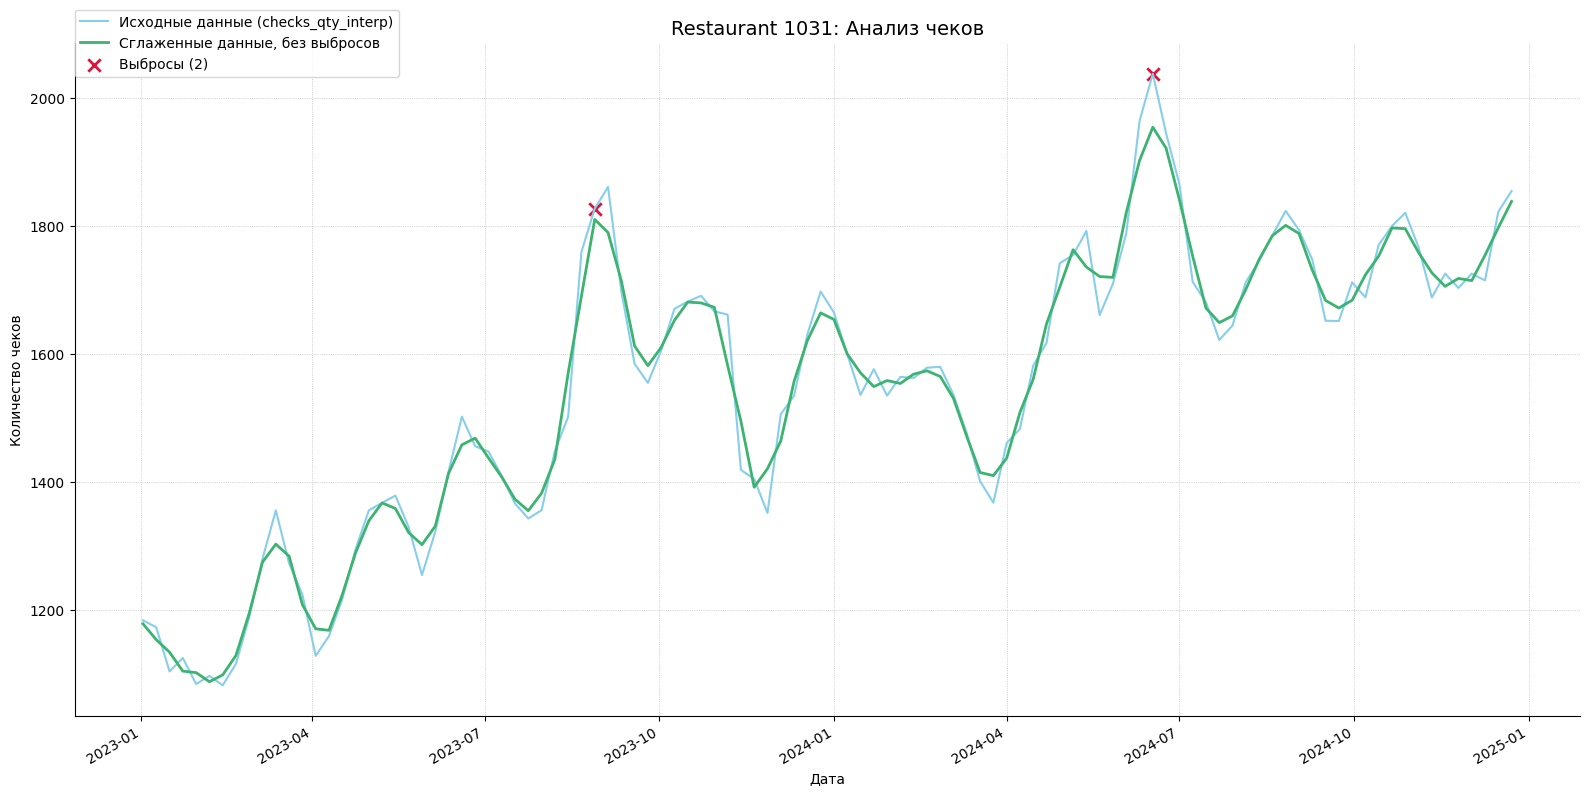

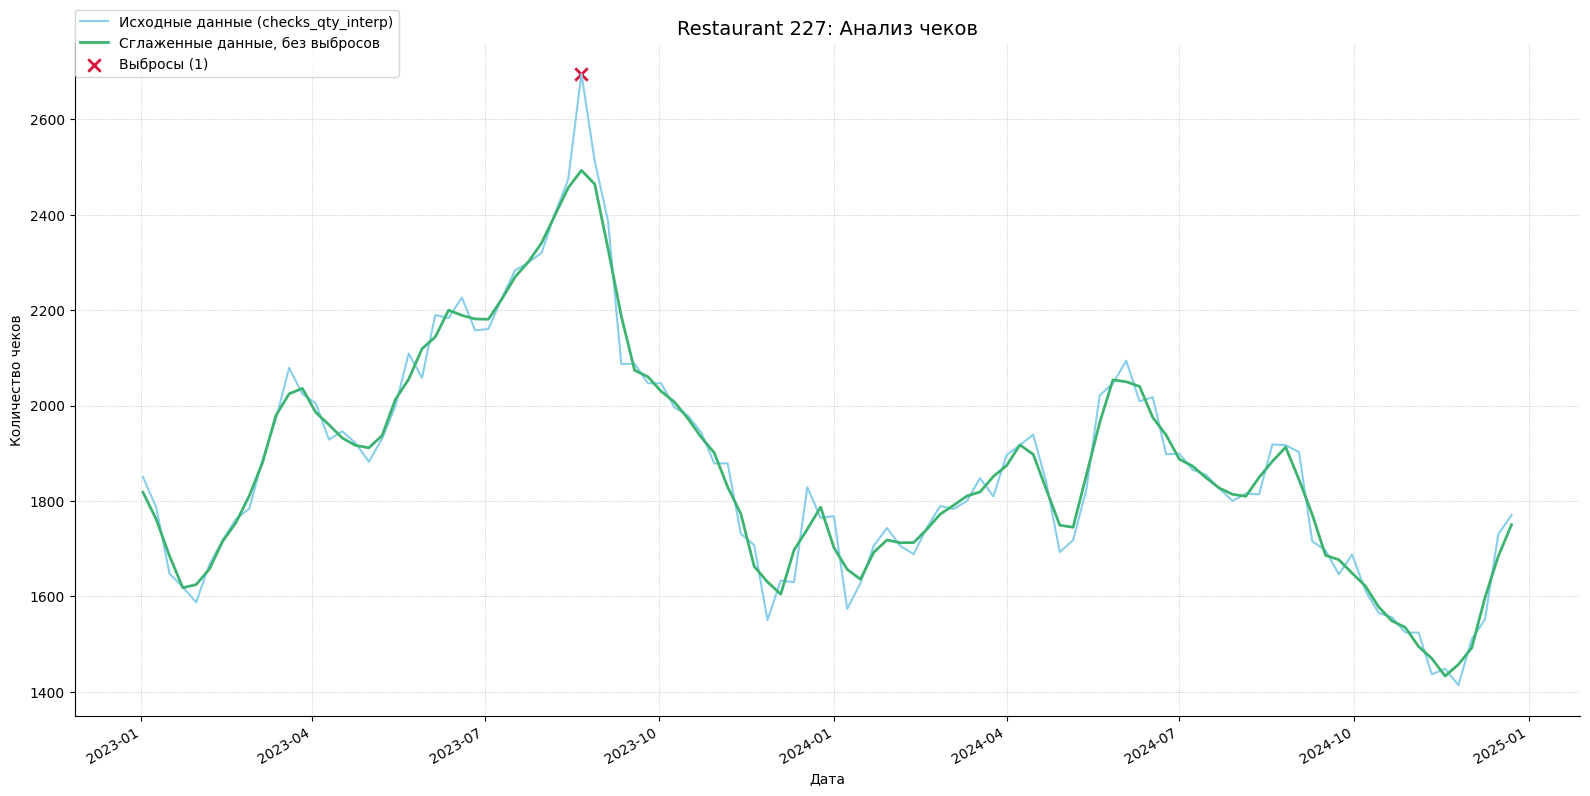

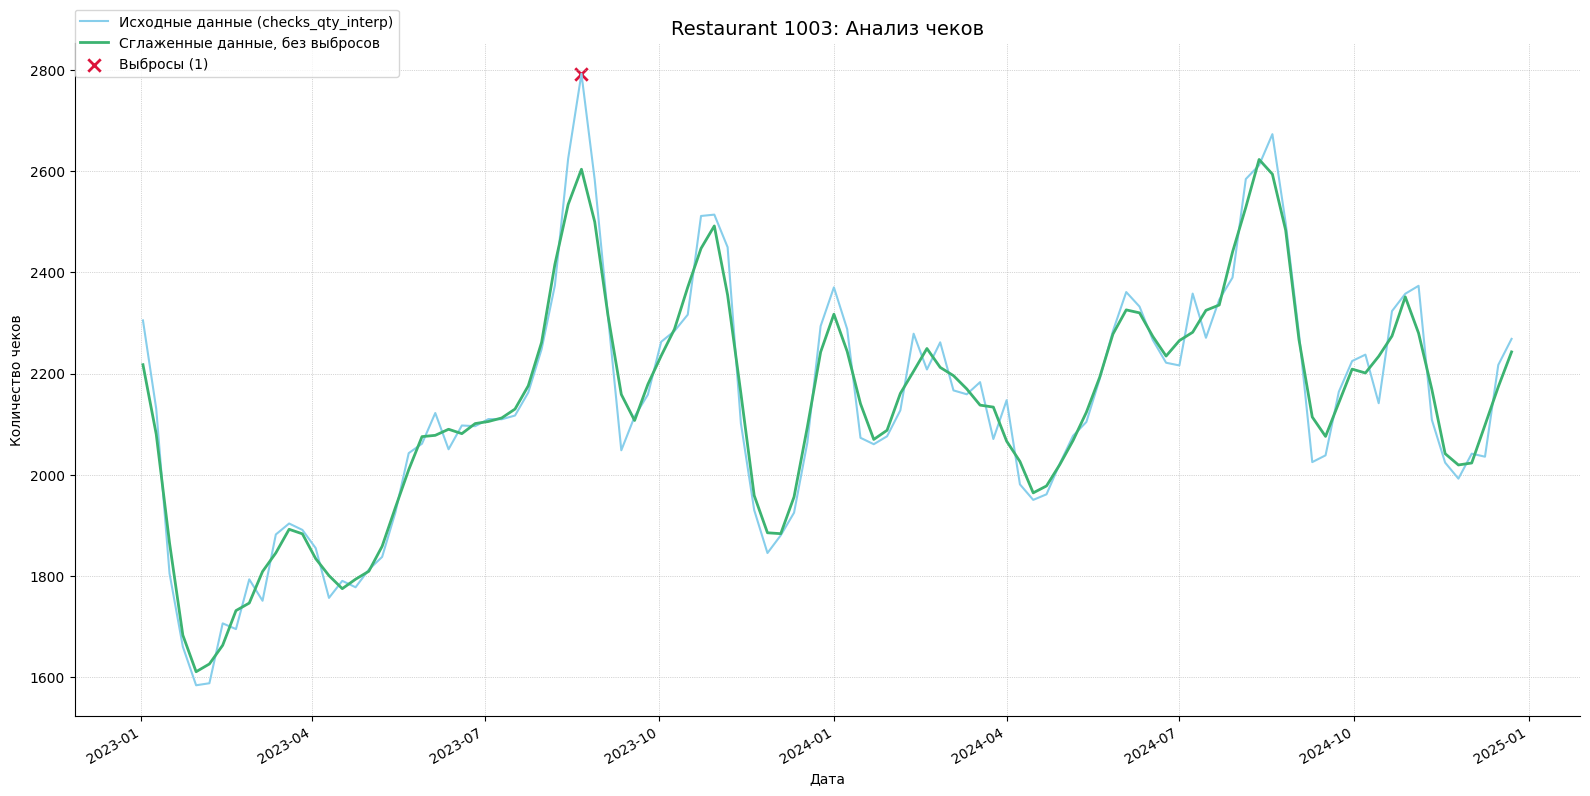

In [7]:
restaurants_with_outliers = weekly_checks_full[weekly_checks_full['is_outlier']]['rest_ncode'].unique()
num_restaurants_to_plot = 3
sample_restaurants = restaurants_with_outliers[:min(num_restaurants_to_plot, len(restaurants_with_outliers))]

for rest_ncode in sample_restaurants:
    restaurant_data = weekly_checks_full[weekly_checks_full['rest_ncode'] == rest_ncode]
    plot_restaurant_data(restaurant_data, 'checks_qty_interp', 'is_outlier')

In [8]:
len(restaurants_with_outliers)

243

## 8. Расчет коэффициентов сезонности

Вычисляем коэффициенты сезонности для каждого ресторана и каждой недели. \
Коэффициент сезонности рассчитывается как отношение среднего количества чеков за данную неделю в данном ресторане к среднему количеству чеков за все недели в данном ресторане.  Полученные коэффициенты сглаживаются с помощью скользящего среднего.

In [9]:
weekly_avg = calculate_seasonality_coefficients(weekly_checks_full, 'checks_qty_interp_filtered')
table1, table2_count, table3 = create_result_tables(weekly_avg)

## 9. Вывод результатов

In [10]:
# 9. Вывод результатов
print("Таблица 1: Ресторан - Кол-во недель с заполненным коэфф-том")
display(table1)

print("\nТаблица 2: Кол-во ресторано-недель с коэфф-том больше 2 или меньше 0.4")
print(table2_count)

print("\nТаблица 3: Ресторан - Неделя - Коэфф-т сезонности")
display(table3)

Таблица 1: Ресторан - Кол-во недель с заполненным коэфф-том


,Ресторан,Кол-во недель c заполненным коэфф-том
0,1,104
1,2,104
2,3,104
3,4,104
4,5,104
...,...,...
864,9060,104
865,9061,104
866,9062,104
867,9063,104



Таблица 2: Кол-во ресторано-недель с коэфф-том больше 2 или меньше 0.4
4845

Таблица 3: Ресторан - Неделя - Коэфф-т сезонности


,Ресторан,Неделя,Коэфф-т сезонности
0,1031,1,0.754120
1,1031,2,0.747216
2,1031,3,0.731265
3,1031,4,0.720159
4,1031,5,0.710215
...,...,...,...
90371,1165,48,1.000000
90372,1165,49,1.000000
90373,1165,50,1.000000
90374,1165,51,1.000000


### Рестораны с недостаточными данными

Обнаружены рестораны **1159, 1040, 9006, 1165** с малым объемом данных, вероятно, это новые рестораны.

**Проблема:**  Недостаток данных делает расчет сезонности для них **ненадежным**.

**Решение:** Коэффициенты сезонности, которые не удалось рассчитать (NaN), заменены на **1.0**.

**Интерпретация:** Значение **1.0** для коэффициента сезонности sparse ресторанов следует интерпретировать как **нейтральную сезонность**, что является **предположением из-за недостатка данных.**  Реальная сезонность для этих ресторанов остается **неопределенной**. При анализе результатов, данные по этим ресторанам следует рассматривать с осторожностью, учитывая, что их коэффициенты сезонности являются **приближением из-за ограниченности данных.**